# Supervised Machine Learning with Random Forest and Sampling

Tram Duong
<br>November 2, 2020

## Table of Contents:
* [Part 1: EDA and FE](#Part_1)
* [Part 2: Data Preparation](#Part_2)
* [Part 3: Supervised Learning](#Part_3)

## Part 1: EDA and FE <a class="anchor" id="Part_1"></a>
- Data Exploration
- Data Cleaning
- Feature Engineerings

In [1]:
import numpy as np
import datetime
import h2o 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
data = pd.read_csv("/Github/Data/XYZloan_default_selected_vars.csv")

### Data Preprocessing

#### Exploring the data
*Following cell output was not included to save space in report*

In [3]:
#data.info()
#data.describe()
#data.head()

#### The two columns  unnamed 0 and unnamed 0.1 do  not contain any important information for our target, leading me to drop them.

In [4]:
data = data.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

#### -99 and -999:

By looking through the dataset, there are numerious amount for "-99" and "-999" in the data. These values are most likely NAs that are handled differently by separate systems and seem to be hold no actual value. Thus, I will replace them with **na** for futher analysis. 

In [5]:
data = data.replace(-99, np.nan)
data = data.replace(-999, np.nan)

In [6]:
#data.head()

**Null Values**

In [7]:
# Proportuib of null value for the entire data
null_prop = round(sum(data.isnull().sum()) /(data.shape[1] * data.shape[0]),2) * 100
print("There is " + str(null_prop) + " % of the data is missing" )

There is 11.0 % of the data is missing


In [8]:
# Proportion of null values in each columns
null_cols = data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]
null_cols = null_cols.sort_values(ascending=False)

In [9]:
null_cols[:10]

TD048    99.99875
TD055    99.99875
TD062    99.99875
TD044    99.99625
TD051    99.99375
TD061    99.98750
TD054    99.98500
TD022    24.49750
TD023     9.57875
TD024     4.61750
dtype: float64

#### From this information, we can see that some features won't be relevant in our analysis as there are too many missing values (over 99% of the data is null). Therefore, I removed those variables as they do not provide useful information to work with.

In [10]:
# Create a list of dropped columns 
# The count function do not count null value.
data_prep = data[[column for column in data if data[column].count() / len(data) >= 0.1]]
# The list of droping features
null_list = []
for c in data.columns:
    if c not in data_prep.columns:
        null_list.append(c)

In [11]:
# Create the new dataframe we will work on
all_col = data.columns.to_list()
selected_columns = [column for column in all_col if column not in set(null_list)]
data = data[selected_columns]

In [12]:
# The data now has dropped 9 columns 
data.head()

,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,1,31,2,1,12,2017/7/6 10:21,ios,3,3,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,2,0,27,1,1,12,2017/4/6 12:51,h5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEB
2,3,0,33,1,4,12,2017/7/1 14:11,h5,4,2,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,4,0,34,2,4,12,2017/7/7 10:10,android,5,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,5,0,47,2,1,12,2017/7/6 14:37,h5,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEB


*Now I look at the others null values columns to see how to deal with them*

In [13]:
null_cols = data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]
null_cols = null_cols.sort_values(ascending=False)
#null_cols

After running some basic functions and checking the data dictionary, the columns that have missing values are all numeric type and are mostly related to the phone info, call details and credit center. Due to the type and the category of these variables, I assume that the missing values were either never provided to the company or were never recorded. 

For this dataset, instead of removing these missing valua, I will impute 0 to all of them in order to not exclude or mispresent any essential data. Thus, with 0 value, I can assume that there is no info for phone, call, bank, or loan to these users while still keeping the information available to me.

In [14]:
data = data.fillna(0)

***Categorical Data and Time Data***

From the dictionary and data exploration, there are 3 variables that not numeric datatypes which are AP005, AP006, and MB007. 
  - AP005: DATETIME
  - AP006: OS_TYPE
  - MB007: MOBILE_BRAND

In [15]:
data.select_dtypes(exclude=['int64', 'float64']).columns

Index(['AP005', 'AP006', 'MB007'], dtype='object')

In [16]:
AP006_df = pd.DataFrame(data.AP006.value_counts())
AP006_df

,AP006
h5,44246
ios,17159
android,17140
api,1455


AP006 is good for a categorical column as the entire column only consists of 4 different values.

In [17]:
MB007_df = pd.DataFrame(data.MB007.value_counts())
MB007_df['Cum_Percentage'] = MB007_df.cumsum()/ len(data) *100
#len(MB007_df)
#MB007_df[1:11]

*The column MB007 contains 112 categorical values, but there are 11 values contibute to approximately 95% of the data, including the "Noinfo" value. Thus, I renamed the other 5% of categorical values as "Other"*

In [18]:
data['MB007'] = data['MB007'].apply(lambda i: i if i in MB007_df[:11].index else 'Other')

In [19]:
from sklearn.preprocessing import LabelEncoder
def create_dummies(df):
    for i in df.columns:
        if df[i].dtypes=='object':
            print(i,'encoded')
            mask = ~df[i].isnull()
            label_encoder = LabelEncoder() 
            try:
                df[i][mask] = label_encoder.fit_transform(df[i][mask])
                df[i] = df[i].astype(int)
            except Exception as e:
                print(e)
    return df

In [20]:
data = create_dummies(data)

AP005 encoded
AP006 encoded
MB007 encoded


In [21]:
# AP004 is for loan term appication which only contains value of: 3,6,9,12. 
AP004_df = pd.DataFrame(data.AP004.value_counts())
#AP004_df
data = data.drop(columns = "AP004")

###### AP004

As the majority of users choose 12 month term, this column does would skew the analysis due to its large proportion value. Therefore, I dropped this column. 

***DateTime values***

The column AP005 represents the data and time recording. Instead of leaving it as be, I broke the information into two separate columns, date and time, to allow for easier formatting before removing the original column.

In [22]:
data['AP005'] = pd.to_datetime(data['AP005'])
data['Date'] = data['AP005'].dt.strftime('%d/%m/%Y')
data['Time'] = data['AP005'].dt.strftime('%H:%M')
data = data.drop(columns = "AP005")

**Duplicated values**

In [23]:
# Check duplciation values
duplicate = sum(data.id.duplicated())
print("There is " + str(duplicate) + " duplicated value" )

There is 0 duplicated value


## Part 2: Data Preparation <a class="anchor" id="Part_2"></a>


### Feature Correlation 

In [24]:
x = data.drop(columns = "loan_default", axis = 1)
y = data.loan_default.values

<AxesSubplot:>

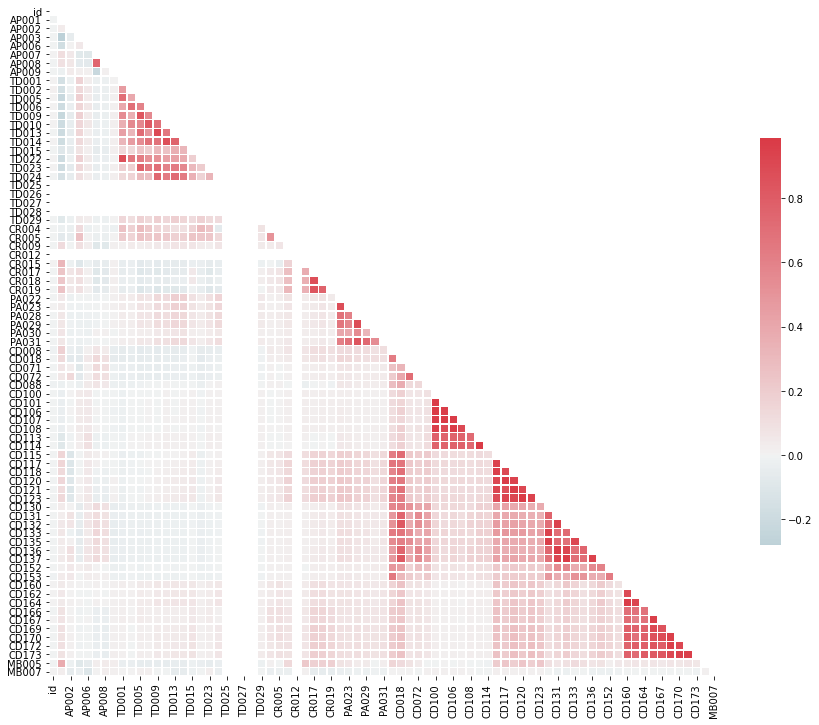

In [25]:
corr = x.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In general, feautures that are overly correlated do not improve model efficiency and also affect the performance of linear regression and random forest models, making the learning algorithms slower to create and train. Therefore, I removed highly correlated features to prevent multicollinearity throughout the following function:

In [26]:
# Function to remove collum with high correlation value
def correlation(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

In [27]:
data = correlation(data, 0.80)
data_new = data.drop(columns = 'id')

Since the models I am planning only works with numerical features, I will convert whichever strings the data may contain to numeric values. Also, the date, time, object data do not work in these model. Therefore, I will drop these columns before working on the models. 

In [28]:
data_clean = data_new.drop(columns = ["Date", "Time"])

In [29]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loan_default  80000 non-null  int64  
 1   AP001         80000 non-null  int64  
 2   AP002         80000 non-null  int64  
 3   AP003         80000 non-null  int64  
 4   AP006         80000 non-null  int32  
 5   AP007         80000 non-null  int64  
 6   AP008         80000 non-null  int64  
 7   AP009         80000 non-null  int64  
 8   TD001         80000 non-null  int64  
 9   TD002         80000 non-null  int64  
 10  TD005         80000 non-null  int64  
 11  TD006         80000 non-null  int64  
 12  TD013         80000 non-null  int64  
 13  TD014         80000 non-null  int64  
 14  TD015         80000 non-null  int64  
 15  TD023         80000 non-null  float64
 16  TD024         80000 non-null  float64
 17  TD025         80000 non-null  float64
 18  TD026         80000 non-nu

**Distribution Plots**

In [30]:
def plot_X_and_Y(var):

    z= data_clean.groupby(var)['loan_default'].agg(['count','mean']).reset_index() 
    z['count_pcnt'] = z['count']/z['count'].sum()
    x = z[var]
    y_mean = z['mean']
    count_pcnt = z['count_pcnt']
    ind = np.arange(0, len(x))
    width = .5

    fig = plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.bar(ind, count_pcnt, width, color='r')
    # plt.ylabel('X')
    plt.title(var + ' Distribution')
    plt.xticks(ind,x.tolist(), rotation=45)

    plt.subplot(122)
    plt.bar(ind, y_mean, width, color='b')
    #plt.ylabel('Y by X')
    plt.xticks(ind,x.tolist(), rotation=45)
    plt.tight_layout()
    plt.title('Response mean by ' + var)
    plt.show()

The clean data has 59 features, which is still a very large number to work with. After further exploration and looking at the variable dictionary, I saw that multiple variables contain a large range of values and thus are not supporting any insight to distribution plot. I removed these variables out of the list of features for distribution plotting.

In [31]:
features_dis = data_clean.drop(columns=['TD025','TD026','TD027','TD028','CR009','CR012',
                                      'PA022','PA028','PA030','CD008','CD018','CD071',
                                      'CD072','CD088','CD100','CD113','CD115','CD130',
                                      'CD131','CD152','CD153','CD160','CD166'])
features_dis = features_dis.columns

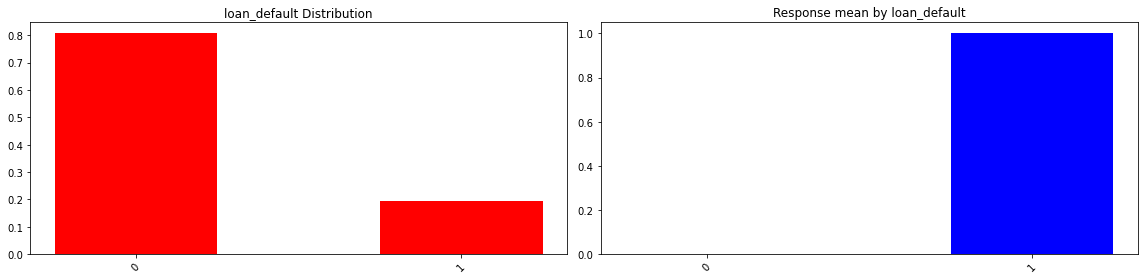

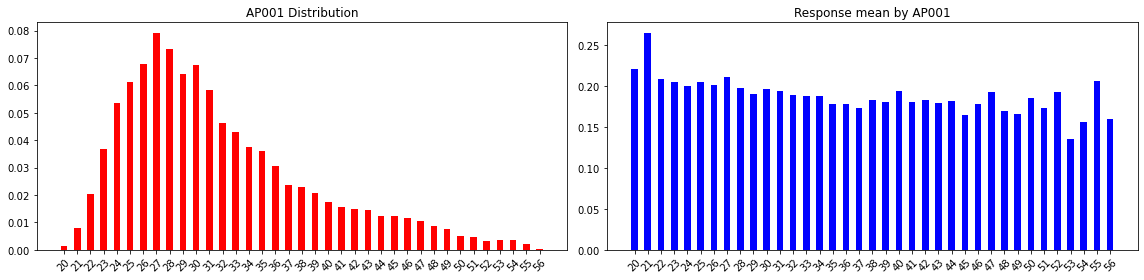

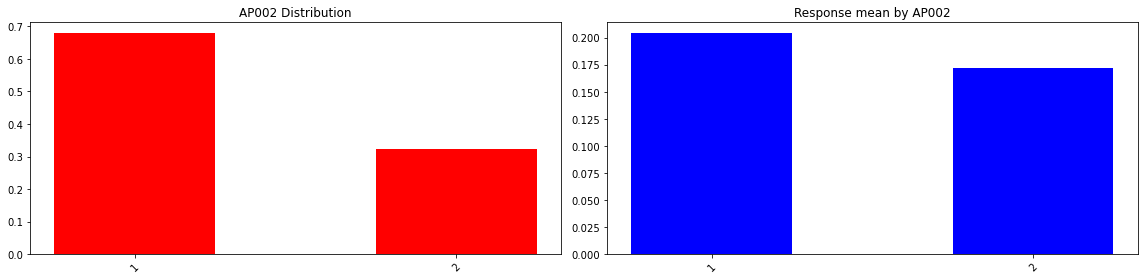

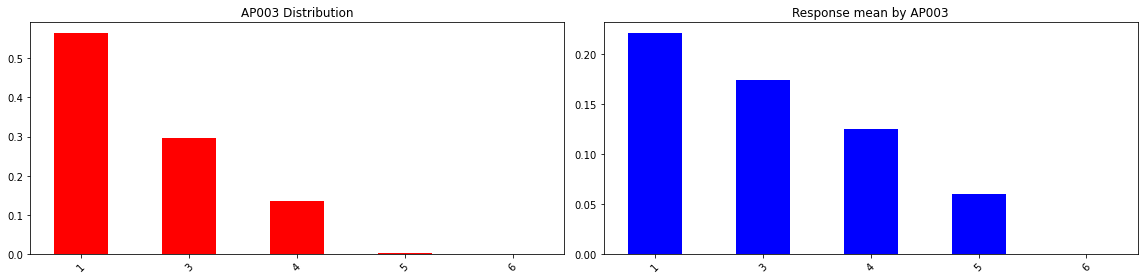

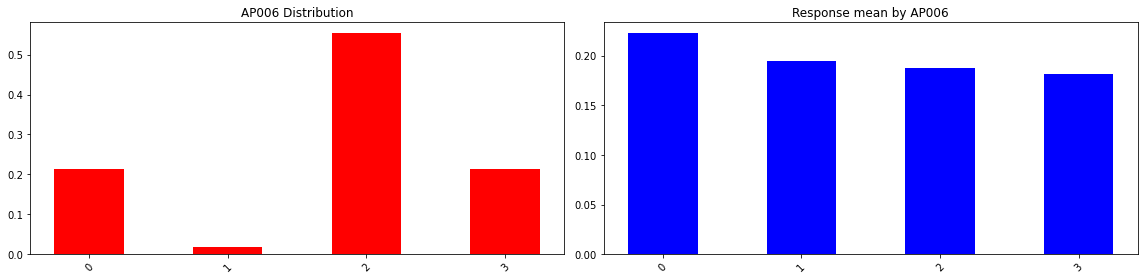

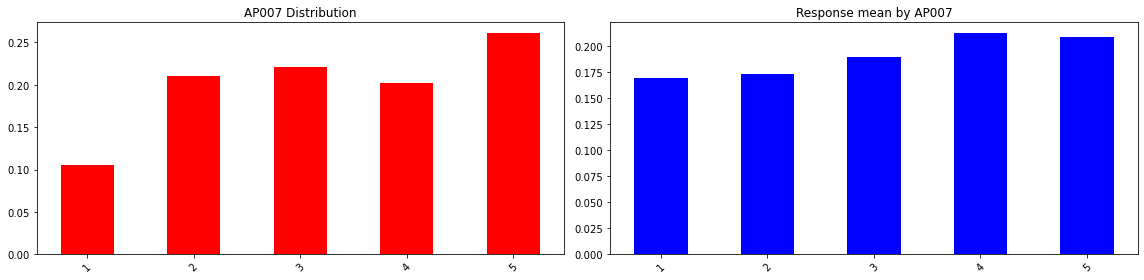

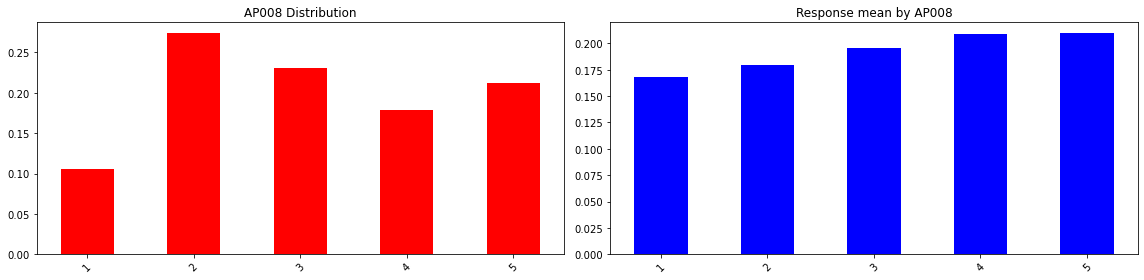

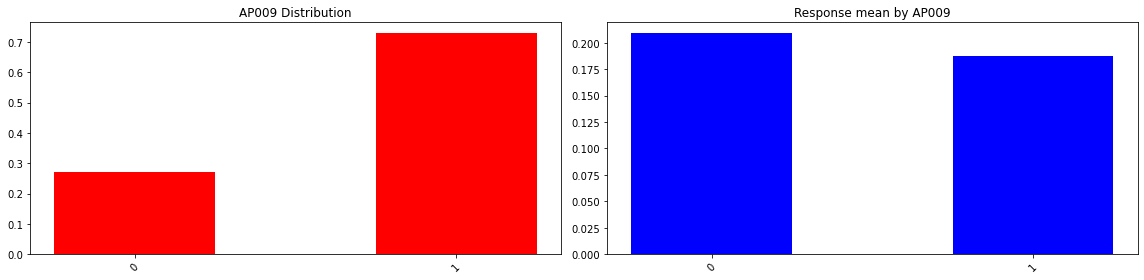

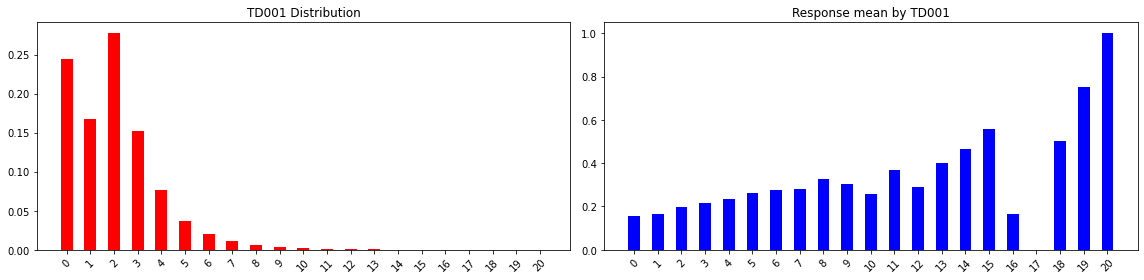

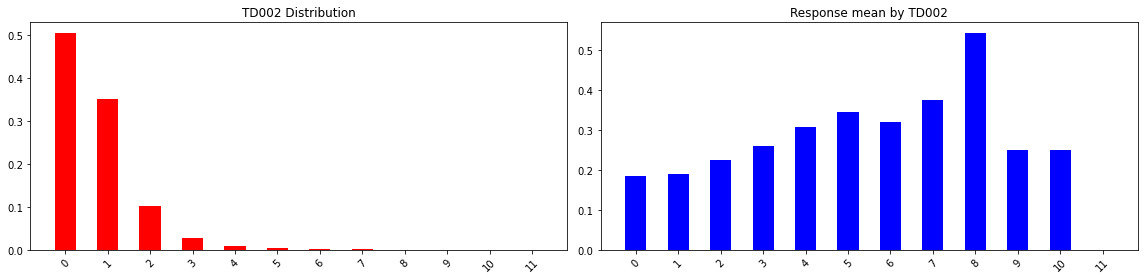

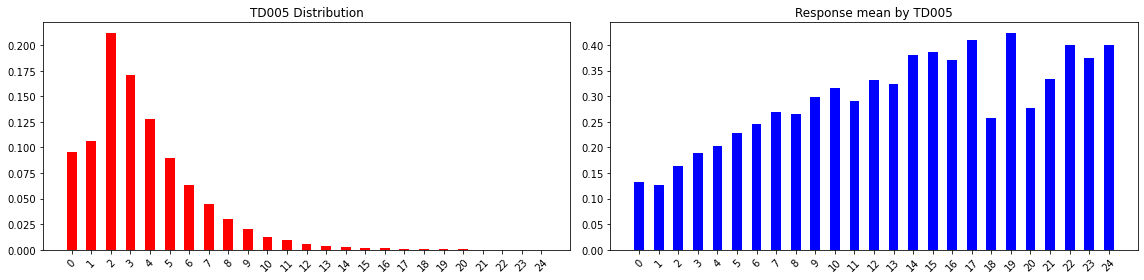

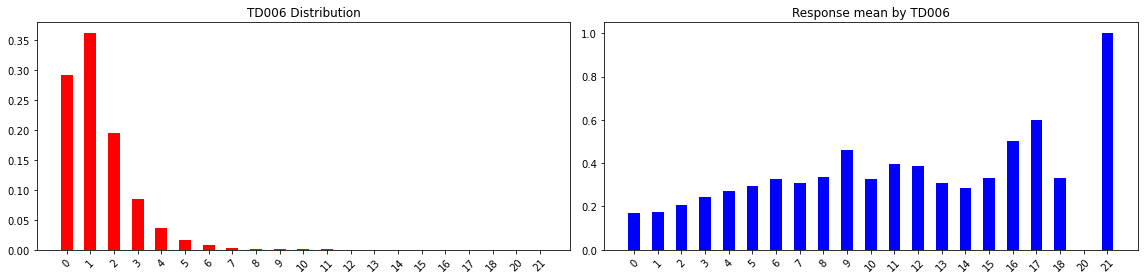

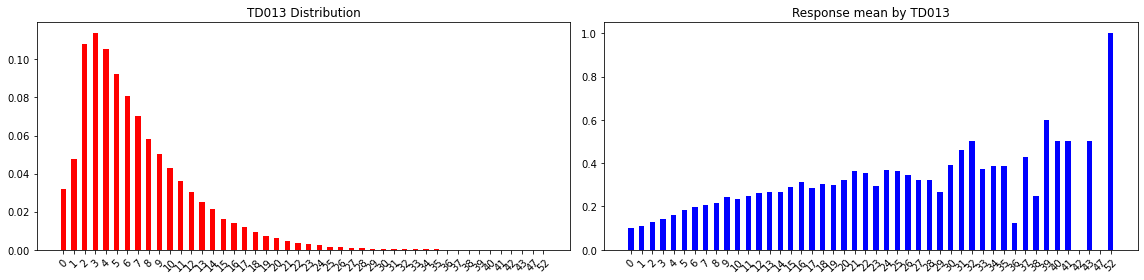

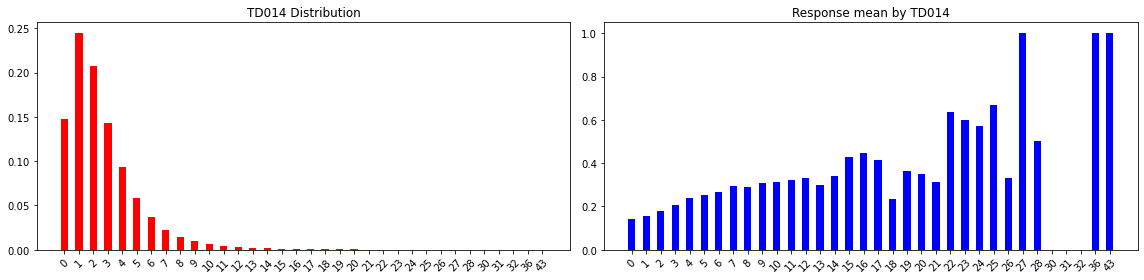

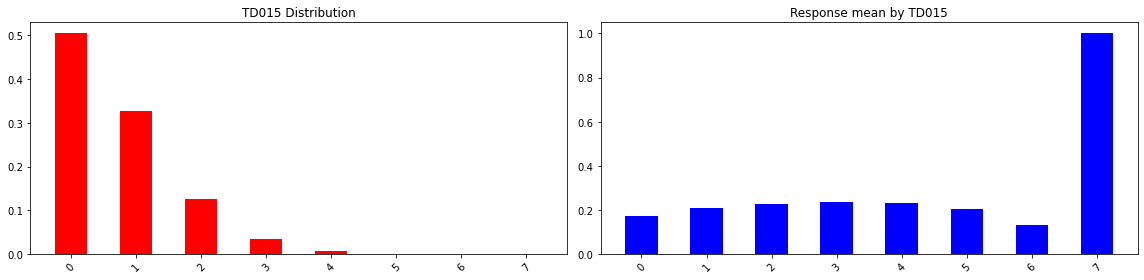

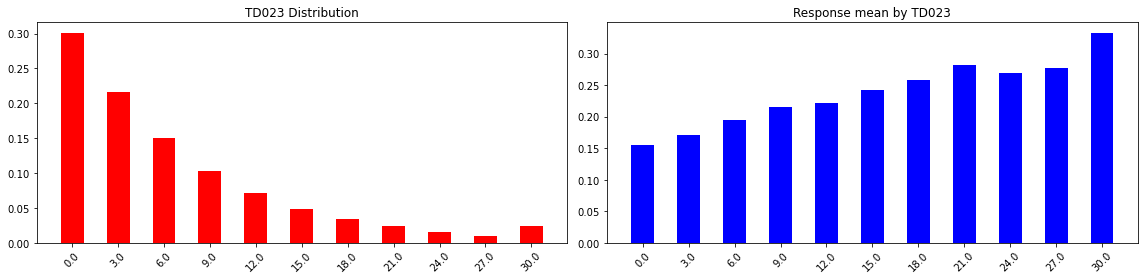

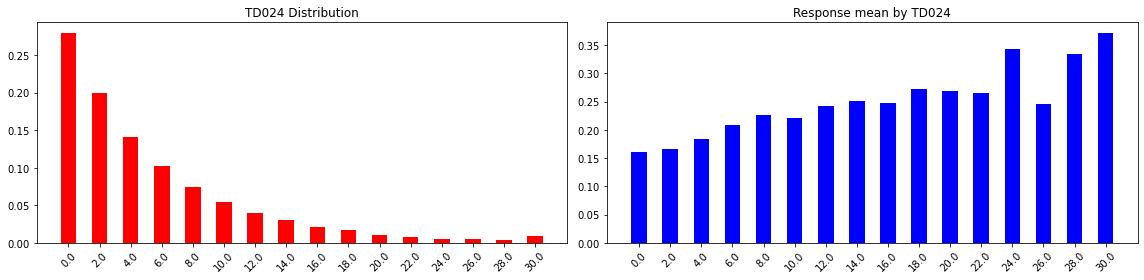

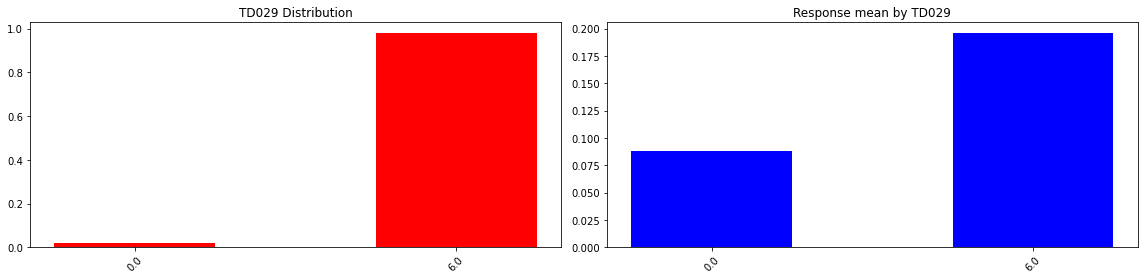

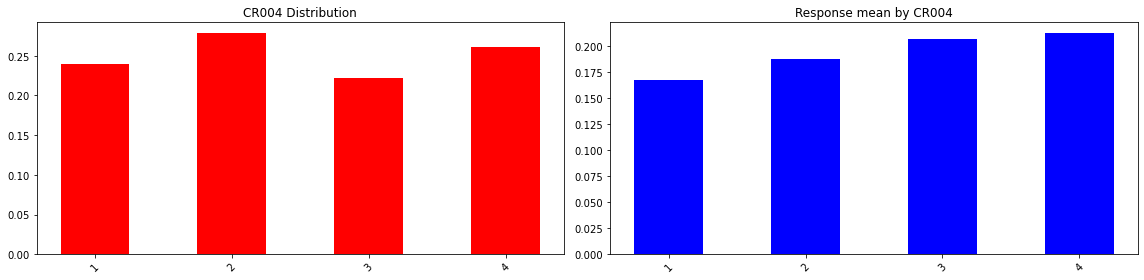

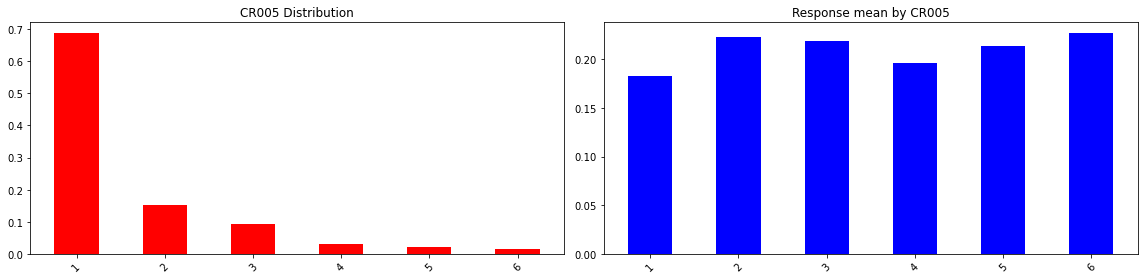

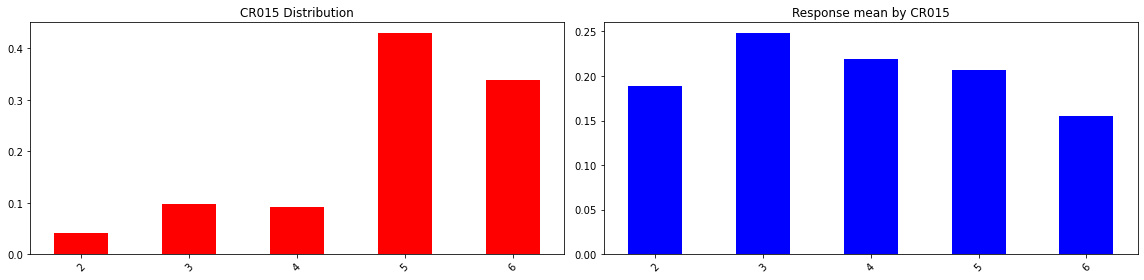

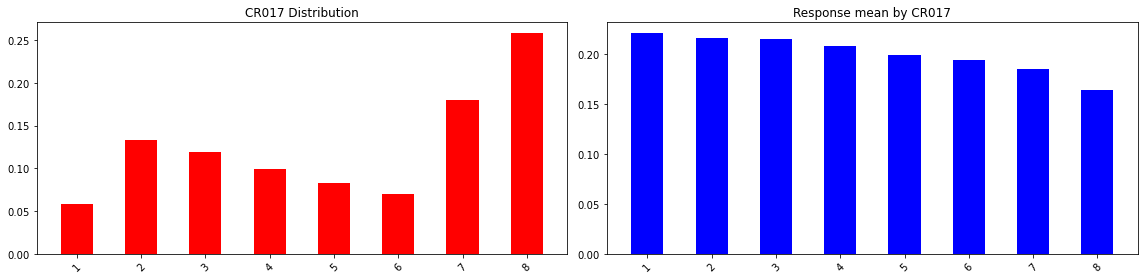

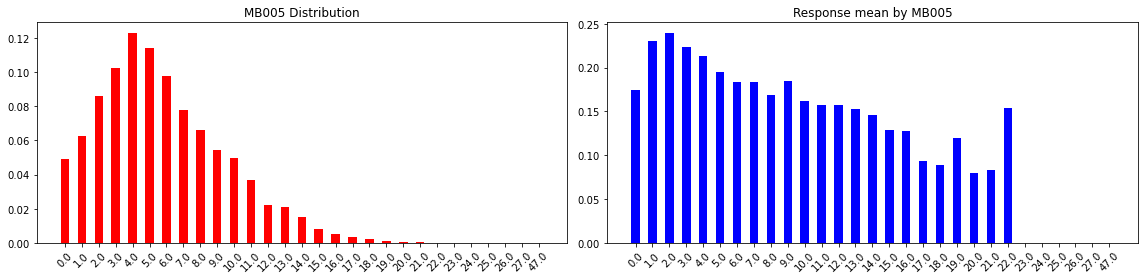

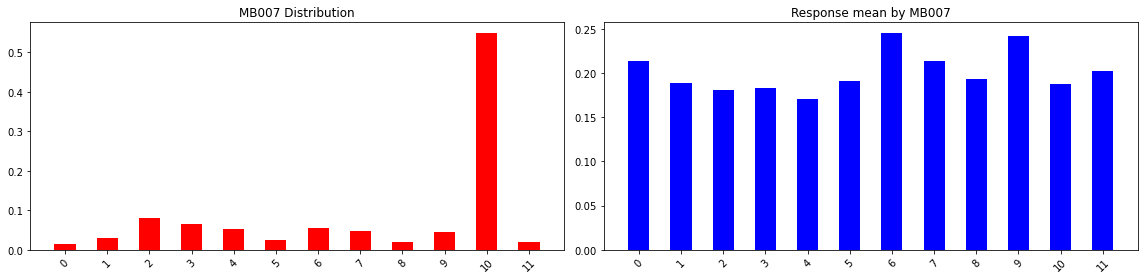

In [32]:
for i in features_dis:
    plot_X_and_Y(i)

#### Split train-test data 

In [34]:
train, test = train_test_split(
    data_clean, test_size=0.30, random_state=23)

target = 'loan_default'
predictors = train.columns[1:]

In [35]:
train['loan_default'].value_counts(dropna=False)

0    45135
1    10865
Name: loan_default, dtype: int64

## Part 3: Supervised Learning with Random Forest <a class="anchor" id="Part_3"></a>

#### Used functions throughout the modeling approach

In [33]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='lightblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()
    

#### Installing: H2O

In [36]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from C:\Users\tramh\.conda\envs\Anomaly\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tramh\AppData\Local\Temp\tmpnphmwdzb
  JVM stdout: C:\Users\tramh\AppData\Local\Temp\tmpnphmwdzb\h2o_tramh_started_from_python.out
  JVM stderr: C:\Users\tramh\AppData\Local\Temp\tmpnphmwdzb\h2o_tramh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_tramh_7q0c05
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.967 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [37]:
# full data
train_full = h2o.H2OFrame(train)
test_full = h2o.H2OFrame(test)

# sample data to test 
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Model 1: 

I started by modeling using the train and test sample dataset. This approach helps to define the code performance before applying them into the entire dataset.

The main difference between AUC and AUCPR is that AUC calculates the area under the ROC curve and AUCPR calculates the area under the Precision Recall curve. The Precision Recall curve does not care about True Negatives. For imbalanced data, a large quantity of True Negatives usually overshadows the effects of changes in other metrics like False Positives. The AUCPR will be much more sensitive to True Positives, False Positives, and False Negatives than AUC. As such, AUCPR is recommended over AUC for highly imbalanced data and should provide more meaningful results.

[Reference](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html?highlight=AUC)

In [38]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 600,
        stopping_metric = "AUCPR",
        nfolds=10,
        min_rows=100,
        seed=1234)

In [39]:
rf_v1.train(list(predictors),target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


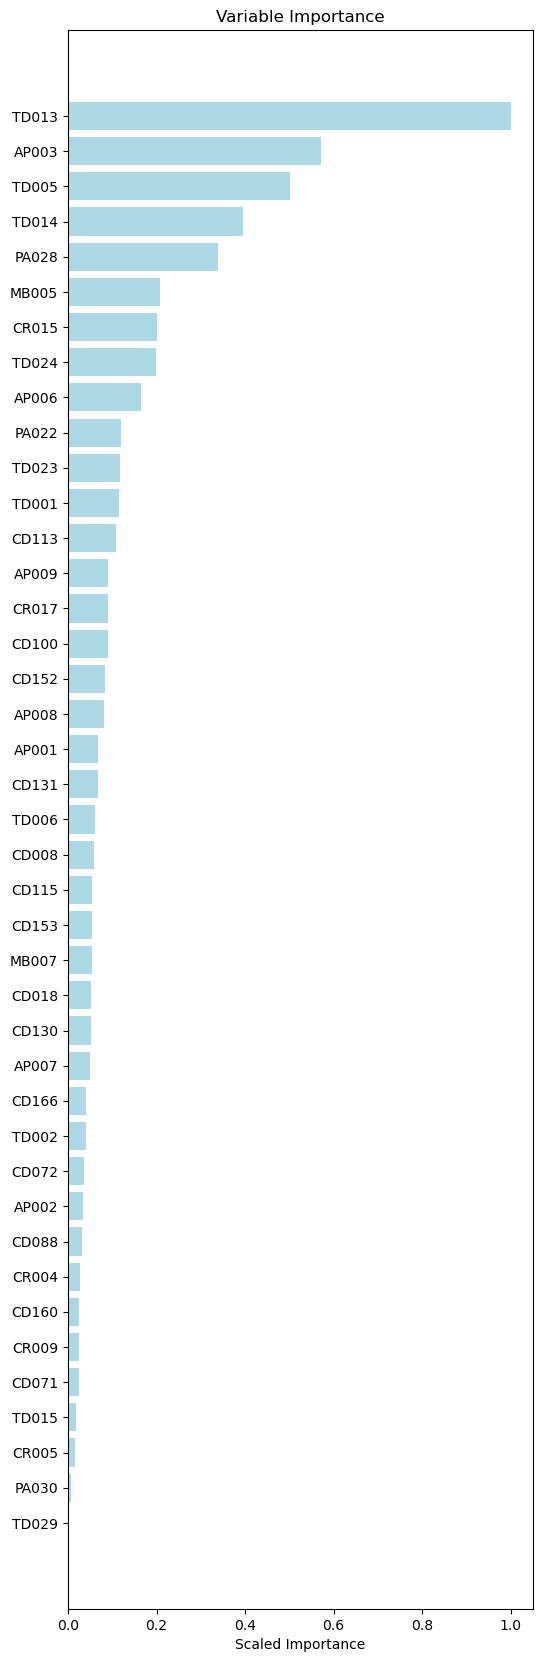

In [40]:
VarImp(rf_v1)

In [41]:
predictions = rf_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,predict
0,0,0.190111
1,0,0.145541
2,0,0.167426
3,0,0.179221
4,0,0.150215


In [42]:
createGains(rf_v1)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,89,151,240,89,151,0.19,0.08,46.8,1.90,11.0,37.08
1,240,66,174,480,155,325,0.33,0.17,93.6,1.66,16.0,32.29
2,240,65,175,720,220,500,0.47,0.26,140.4,1.57,21.0,30.56
3,240,46,194,960,266,694,0.57,0.36,187.2,1.42,21.0,27.71
4,240,42,198,1200,308,892,0.66,0.46,234.0,1.32,20.0,25.67
5,240,52,188,1440,360,1080,0.77,0.56,280.8,1.28,21.0,25.00
6,240,46,194,1680,406,1274,0.87,0.66,327.6,1.24,21.0,24.17
7,240,24,216,1920,430,1490,0.92,0.77,374.4,1.15,15.0,22.40
8,240,21,219,2160,451,1709,0.96,0.88,421.2,1.07,8.0,20.88


The gain table shows that the lift, K_S, and gain scores are fairly good. For example, let's look at decile 0.

- Lift = decile 0 of model 1 has 1.9 times greater lift than random selection.
- K_S= abs(cumulative % of total good loan applicants— cumulative % of total bad loan applicants) -> The higher the value, the better the model is at separating the positive cases from negative ones.

drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



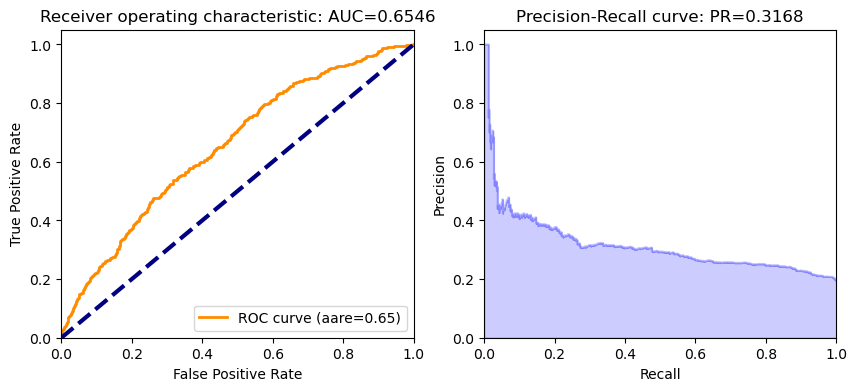

In [43]:
ROC_AUC(rf_v1,test_hex,'loan_default')

### Model 2: 

After testing on small datasets and the results are promising, I apply the same code to the entire dataset. 

In [44]:
rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 600,
        stopping_metric = "AUCPR",
        nfolds=10,
        min_rows=100,
        seed=1234)

In [45]:
rf_v2.train(list(predictors),target,training_frame=train_full)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [46]:
predictions_2 = rf_v2.predict(test_hex)
predictions_2.head()
test_scores_2 = test_hex['loan_default'].cbind(predictions_2).as_data_frame()
test_scores_2.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,predict
0,0,0.172478
1,0,0.109992
2,0,0.138127
3,0,0.184747
4,0,0.103186


In [47]:
createGains(rf_v2)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,93,147,240,93,147,0.20,0.08,46.8,1.99,12.0,38.75
1,240,69,171,480,162,318,0.35,0.16,93.6,1.73,19.0,33.75
2,240,53,187,720,215,505,0.46,0.26,140.4,1.53,20.0,29.86
3,240,55,185,960,270,690,0.58,0.36,187.2,1.44,22.0,28.12
4,240,43,197,1200,313,887,0.67,0.46,234.0,1.34,21.0,26.08
5,240,44,196,1440,357,1083,0.76,0.56,280.8,1.27,20.0,24.79
6,240,34,206,1680,391,1289,0.84,0.67,327.6,1.19,17.0,23.27
7,240,41,199,1920,432,1488,0.92,0.77,374.4,1.15,15.0,22.50
8,240,22,218,2160,454,1706,0.97,0.88,421.2,1.08,9.0,21.02


The gain table of model 2 results in better scores compare to model 1, as well as the AUC score.

drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



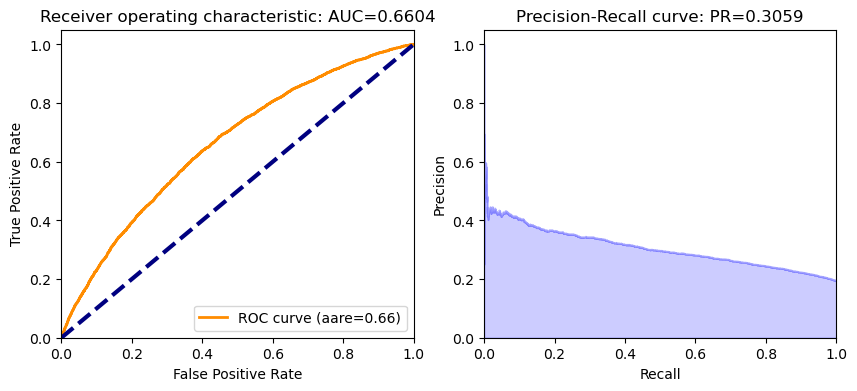

In [48]:
ROC_AUC(rf_v2,test_full,'loan_default')

### Model 3:  Use H2O's "balance_classes"

Given that we have an highly unbalanced dataset, I'm using the H2O balance_classes. The balance_classes option can be used to balance the class distribution. When enabled, H2O will either undersample the majority classes or oversample the minority classes.

In [49]:
rf_v3 = H2ORandomForestEstimator(
        model_id = 'rf_v3',
        ntrees = 300,
        stopping_metric = "AUCPR", 
        nfolds=10,
        min_rows=100,
        balance_classes = True,
        seed=1234)
rf_v3.train(list(predictors),target,training_frame=train_full)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [50]:
predictions_3 = rf_v2.predict(test_hex)
predictions_3.head()
test_scores_3 = test_hex['loan_default'].cbind(predictions_3).as_data_frame()
test_scores_3.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,predict
0,0,0.172478
1,0,0.109992
2,0,0.138127
3,0,0.184747
4,0,0.103186


In [51]:
createGains(rf_v3)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,92,148,240,92,148,0.20,0.08,46.8,1.97,12.0,38.33
1,240,70,170,480,162,318,0.35,0.16,93.6,1.73,19.0,33.75
2,240,55,185,720,217,503,0.46,0.26,140.4,1.55,20.0,30.14
3,240,53,187,960,270,690,0.58,0.36,187.2,1.44,22.0,28.12
4,240,42,198,1200,312,888,0.67,0.46,234.0,1.33,21.0,26.00
5,240,43,197,1440,355,1085,0.76,0.56,280.8,1.26,20.0,24.65
6,240,34,206,1680,389,1291,0.83,0.67,327.6,1.19,16.0,23.15
7,240,42,198,1920,431,1489,0.92,0.77,374.4,1.15,15.0,22.45
8,240,22,218,2160,453,1707,0.97,0.88,421.2,1.08,9.0,20.97


Model 3 has lower results in gain table compare to model 2, but still better than model 1. For AUC, this model also ranked as the second place amoung 3 models.

drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



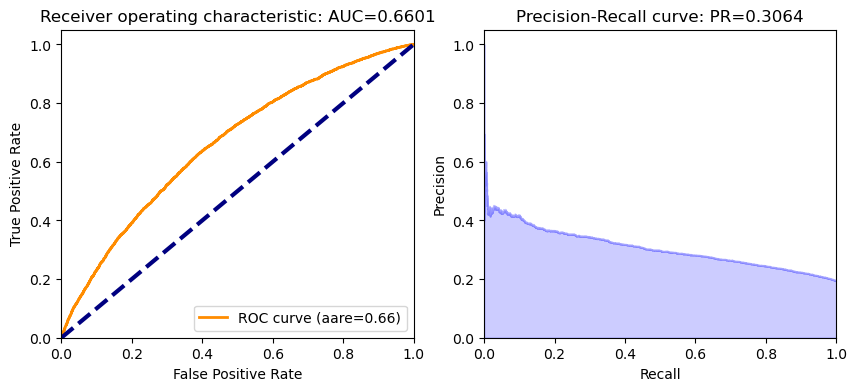

In [52]:
ROC_AUC(rf_v3,test_full,'loan_default')

### Model 4: Hyperparameter Tuning 
In this section, I used H2O Grid-search to find the optimal hyper-parameters for the model.

As 'loan_default' contains binary values represented by 0's and 1's, it is assumed to be numeric in H20 and is applied as such. Thus, it would be trained as a regression model instead of a binary classification model, and AUC is not allowed. I will use as.factor() on that column, just after uploading it into H2O to ensure that column is interpreted correctly.

In [53]:
# sample data to test 
train_smpl_1 = train.sample(frac=0.1, random_state=1)
test_smpl_1 = test.sample(frac=0.1, random_state=1)
train_hex_1 = h2o.H2OFrame(train_smpl_1)
test_hex_1 = h2o.H2OFrame(test_smpl_1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [54]:
# For the full data 
#train_full[target] = train_full [target].asfactor()
#test_full[target] = test_full[target].asfactor()
# For sample data to test
train_hex_1[target] = train_hex_1[target].asfactor()
#test_hex[target] = test_hex[target].asfactor()

In [55]:
rf_v4 = H2ORandomForestEstimator(nfolds = 5,seed = 1234,balance_classes = True)

hyper_params = {'max_depth': [1, 5,10,20],
                 'ntrees': [200,400,600, 800]}

rf_grid = H2OGridSearch(model = rf_v4, hyper_params = hyper_params,
                     search_criteria = {'strategy': "RandomDiscrete",'max_models': 30, 
                                        'seed': 1,"stopping_metric": "AUCPR",
                                        "stopping_tolerance": 1e-4, 
                                        "stopping_rounds": 5})

In [56]:
rf_grid.train(x = list(predictors), y = target, training_frame=train_hex_1)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [57]:
# Get the grid results, sorted by validation AUC
sorted_rf_grid = rf_grid.get_grid(sort_by='auc',decreasing=True)
best_rf = sorted_rf_grid.models[0]

In [58]:
print(best_rf)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  Grid_DRF_py_13_sid_9c55_model_python_1604352498129_1_model_3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,800.0,800.0,3051870.0,10.0,10.0,10.0,161.0,403.0,298.16




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.23676255438870758
RMSE: 0.48658252577410505
LogLoss: 0.645491325489853
Mean Per-Class Error: 0.12036748445533774
AUC: 0.9545834413505689
AUCPR: 0.9565482862869644
Gini: 0.9091668827011379

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.206981036479151: 


,,0,1,Error,Rate
0,0,3911.0,609.0,0.1347,(609.0/4520.0)
1,1,496.0,4010.0,0.1101,(496.0/4506.0)
2,Total,4407.0,4619.0,0.1224,(1105.0/9026.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.206981,0.878904,256.0
1,max f2,0.158301,0.917593,298.0
2,max f0point5,0.258163,0.904306,217.0
3,max accuracy,0.225276,0.879681,241.0
4,max precision,0.661631,1.000000,0.0
5,max recall,0.095665,1.000000,356.0
6,max specificity,0.661631,1.000000,0.0
7,max absolute_mcc,0.225276,0.760804,241.0
8,max min_per_class_accuracy,0.211429,0.878982,252.0
9,max mean_per_class_accuracy,0.225276,0.879633,241.0



Gains/Lift Table: Avg response rate: 49.92 %, avg score: 23.66 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010082,0.557453,2.003107,2.003107,1.000000,0.589794,1.000000,0.589794,0.020195,0.020195,100.310697,100.310697,0.020195
1,2,0.020053,0.529356,2.003107,2.003107,1.000000,0.542790,1.000000,0.566422,0.019973,0.040169,100.310697,100.310697,0.040169
2,3,0.030024,0.511138,2.003107,2.003107,1.000000,0.519249,1.000000,0.550756,0.019973,0.060142,100.310697,100.310697,0.060142
3,4,0.040106,0.496710,2.003107,2.003107,1.000000,0.503813,1.000000,0.538955,0.020195,0.080337,100.310697,100.310697,0.080337
4,5,0.050078,0.480812,2.003107,2.003107,1.000000,0.488699,1.000000,0.528948,0.019973,0.100311,100.310697,100.310697,0.100311
5,6,0.100044,0.424116,2.003107,2.003107,1.000000,0.449688,1.000000,0.489362,0.100089,0.200399,100.310697,100.310697,0.200399
6,7,0.150011,0.387749,1.980900,1.995710,0.988914,0.404084,0.996307,0.460957,0.098979,0.299379,98.089957,99.570997,0.298272
7,8,0.200089,0.357374,1.963222,1.987579,0.980088,0.372606,0.992248,0.438845,0.098313,0.397692,96.322210,98.757901,0.394595
8,9,0.300022,0.307329,1.927602,1.967601,0.962306,0.331998,0.982275,0.403256,0.192632,0.590324,92.760183,96.760138,0.579705
9,10,0.400066,0.257892,1.705857,1.902147,0.851606,0.282954,0.949598,0.373172,0.170661,0.760985,70.585743,90.214727,0.720720




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.15102772513540358
RMSE: 0.3886228571962843
LogLoss: 0.47577934005630707
Mean Per-Class Error: 0.37366027531956736
AUC: 0.6641486397902326
AUCPR: 0.31305383378431545
Gini: 0.3282972795804653

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14684065158575366: 


,,0,1,Error,Rate
0,0,2925.0,1595.0,0.3529,(1595.0/4520.0)
1,1,426.0,654.0,0.3944,(426.0/1080.0)
2,Total,3351.0,2249.0,0.3609,(2021.0/5600.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.146841,0.392911,216.0
1,max f2,0.093896,0.561699,310.0
2,max f0point5,0.171283,0.333470,176.0
3,max accuracy,0.346744,0.807857,16.0
4,max precision,0.388885,0.600000,6.0
5,max recall,0.034370,1.000000,398.0
6,max specificity,0.461535,0.999779,0.0
7,max absolute_mcc,0.156135,0.203516,200.0
8,max min_per_class_accuracy,0.142852,0.623148,222.0
9,max mean_per_class_accuracy,0.146841,0.626340,216.0



Gains/Lift Table: Avg response rate: 19.29 %, avg score: 14.02 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.314313,2.592593,2.592593,0.500000,0.355131,0.500000,0.355131,0.025926,0.025926,159.259259,159.259259,0.019731
1,2,0.02,0.287325,2.314815,2.453704,0.446429,0.297988,0.473214,0.326559,0.023148,0.049074,131.481481,145.370370,0.036021
2,3,0.03,0.273643,1.481481,2.129630,0.285714,0.279466,0.410714,0.310862,0.014815,0.063889,48.148148,112.962963,0.041986
3,4,0.04,0.261543,2.592593,2.245370,0.500000,0.267873,0.433036,0.300114,0.025926,0.089815,159.259259,124.537037,0.061717
4,5,0.05,0.253599,1.481481,2.092593,0.285714,0.257472,0.403571,0.291586,0.014815,0.104630,48.148148,109.259259,0.067683
5,6,0.10,0.222775,1.888889,1.990741,0.364286,0.237512,0.383929,0.264549,0.094444,0.199074,88.888889,99.074074,0.122747
6,7,0.15,0.203773,1.462963,1.814815,0.282143,0.212230,0.350000,0.247109,0.073148,0.272222,46.296296,81.481481,0.151426
7,8,0.20,0.189758,1.314815,1.689815,0.253571,0.196758,0.325893,0.234522,0.065741,0.337963,31.481481,68.981481,0.170928
8,9,0.30,0.165934,1.407407,1.595679,0.271429,0.177817,0.307738,0.215620,0.140741,0.478704,40.740741,59.567901,0.221403
9,10,0.40,0.146845,1.240741,1.506944,0.239286,0.156459,0.290625,0.200830,0.124074,0.602778,24.074074,50.694444,0.251229




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.63339216,0.060881127,0.64499575,0.5351027,0.6223214,0.6903283,0.6742126
1,auc,0.6654752,0.008363225,0.65197897,0.66795117,0.66469514,0.674636,0.6681146
2,aucpr,0.3177904,0.017030368,0.34251213,0.31493726,0.32268253,0.3133214,0.2954986
3,err,0.36660784,0.060881127,0.35500428,0.46489727,0.37767857,0.3096717,0.3257874
4,err_count,412.2,83.39784,415.0,543.0,423.0,349.0,331.0
5,f0point5,0.33257973,0.02614182,0.33761293,0.30431825,0.32768103,0.37393767,0.31934878
6,f1,0.40379867,0.01786044,0.4062947,0.3973363,0.40338504,0.43066883,0.3813084
7,f2,0.5175354,0.035954196,0.51005745,0.57225066,0.52457815,0.50769234,0.47309834
8,lift_top_group,2.5401468,0.8786933,3.7954545,3.0829563,2.1406727,1.6404657,2.0411854
9,logloss,0.4752418,0.017334543,0.4854248,0.46821377,0.47960383,0.49386168,0.449105



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-11-02 16:50:11,2 min 6.834 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-11-02 16:50:11,2 min 6.861 sec,1.0,0.513185,1.199601,0.742498,0.712600,1.655536,0.370245
2,,2020-11-02 16:50:11,2 min 6.873 sec,2.0,0.507847,1.314510,0.760105,0.714712,1.561004,0.321422
3,,2020-11-02 16:50:11,2 min 6.886 sec,3.0,0.507421,1.268220,0.770557,0.724050,1.527369,0.308975
4,,2020-11-02 16:50:11,2 min 6.904 sec,4.0,0.501674,1.136477,0.790257,0.749886,1.564070,0.294607
5,,2020-11-02 16:50:11,2 min 6.923 sec,5.0,0.500463,1.016178,0.802394,0.761718,1.573870,0.282210
6,,2020-11-02 16:50:11,2 min 6.943 sec,6.0,0.499454,0.913544,0.811844,0.772524,1.597414,0.276883
7,,2020-11-02 16:50:11,2 min 6.965 sec,7.0,0.497051,0.819577,0.823319,0.788646,1.646999,0.256804
8,,2020-11-02 16:50:11,2 min 6.987 sec,8.0,0.497002,0.794552,0.832858,0.801345,1.614444,0.248806
9,,2020-11-02 16:50:11,2 min 7.010 sec,9.0,0.496142,0.765382,0.842627,0.815644,1.606452,0.249691



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,28246.951172,1.000000,0.060145
1,TD005,21326.464844,0.755001,0.045409
2,MB005,19927.867188,0.705487,0.042431
3,AP003,18405.435547,0.651590,0.039190
4,TD014,18105.884766,0.640985,0.038552
5,AP001,16733.414062,0.592397,0.035630
6,TD024,16200.927734,0.573546,0.034496
7,CD008,14725.038086,0.521297,0.031353
8,PA028,14204.986328,0.502886,0.030246
9,TD001,13787.530273,0.488107,0.029357



See the whole table with table.as_data_frame()



The best rf model contains the hyperparameters as in the model summary above. The model metrics also show high scores on AUC and AUCPR (Both are approximately 0.95). Additionaly the other statistics also provide positive insights.  

From all above, I am going to train the model with the full data. 

In [59]:
best_rf.train(list(predictors),target,training_frame=train_full)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [60]:
# Prediction with the best model
predictions_4 = best_rf.predict(test_full)
predictions_4.head()
test_scores_4 = test_full['loan_default'].cbind(predictions_4).as_data_frame()
test_scores_4.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,predict
0,0,0.416000
1,0,0.174541
2,0,0.219001
3,0,0.187464
4,1,0.353922


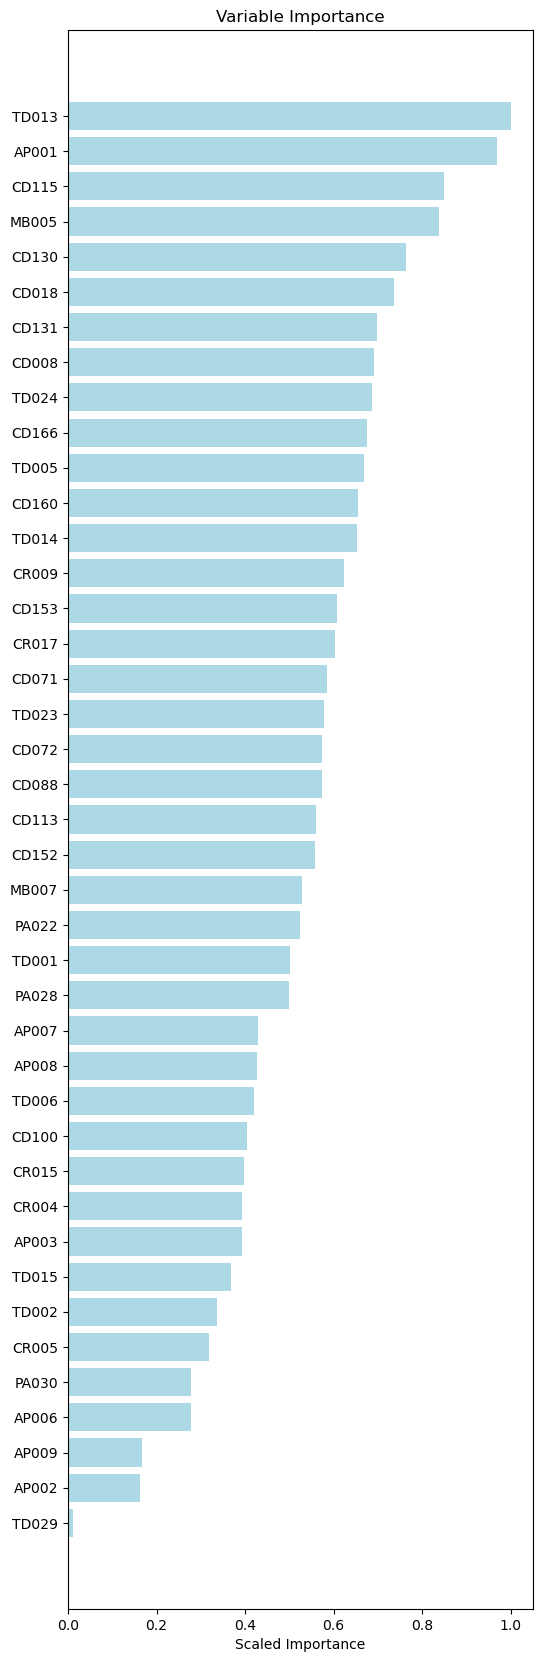

In [61]:
VarImp(best_rf)

In [66]:
createGains(best_rf)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,92,148,240,92,148,0.20,0.08,46.8,1.97,12.0,38.33
1,240,62,178,480,154,326,0.33,0.17,93.6,1.65,16.0,32.08
2,240,60,180,720,214,506,0.46,0.26,140.4,1.52,20.0,29.72
3,240,56,184,960,270,690,0.58,0.36,187.2,1.44,22.0,28.12
4,240,47,193,1200,317,883,0.68,0.46,234.0,1.35,22.0,26.42
5,240,43,197,1440,360,1080,0.77,0.56,280.8,1.28,21.0,25.00
6,240,36,204,1680,396,1284,0.85,0.66,327.6,1.21,19.0,23.57
7,240,34,206,1920,430,1490,0.92,0.77,374.4,1.15,15.0,22.40
8,240,18,222,2160,448,1712,0.96,0.89,421.2,1.06,7.0,20.74


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



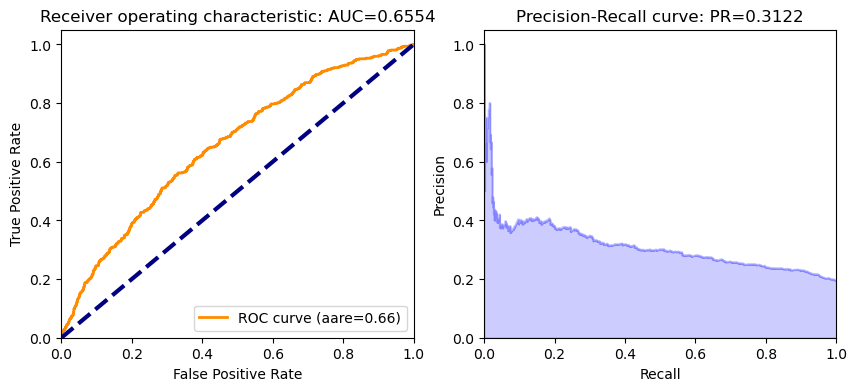

In [67]:
ROC_AUC(best_rf,test_hex,'loan_default')

### Undersampling

Undersampling refers to a group of techniques designed to balance the class distribution for a classification dataset that has a skewed class distribution. 

Undersampling techniques remove examples from the training dataset that belong to the majority class in order to better balance the class distribution, such as reducing the skew from a 1:100 ratio to a 1:10.

There are three major approaches to handle imbalanced data: data sampling, algorithm modifications, and cost-sensitive learning. In this part, I will focus on **undersampling technique** for my approach. There are 7 common undersampling methods, as following: 
- Random under-sampling for the majority class
- NearMiss
- Condensed Nearest Neighbor Rule (CNN)
- TomekLinks
- Edited Nearest Neighbor Rule (ENN)
- NeighbourhoodCleaningRule
- ClusterCentroids

[Reference](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/)

####  Random under-sampling for the majority class
Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset.This has the effect of reducing the number of examples in the majority class in the transformed version of the training dataset.

In random under-sampling (potentially), vast quantities of data are discarded.This can be highly problematic, as the loss of such data can make the decision boundary between minority and majority instances harder to learn, resulting in a loss in classification performance.


In [68]:
from collections import Counter
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)

In [69]:
y = data_clean[target]
X = data_clean.drop(target,axis=1)

In [70]:
# RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy='majority', random_state = 42)
X_rs, y_rs = sampler.fit_sample(X, y)
print('Random undersampling {}'.format(Counter(y_rs)))
df = pd.concat([X_rs,y_rs],axis=1, sort=False)

Random undersampling Counter({0: 15488, 1: 15488})


In [71]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [72]:
rf_v5 = H2ORandomForestEstimator(
        model_id = 'rf_v5',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v5.train(list(predictors),target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [73]:
createGains(rf_v5)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1240,904,336,1240,904,336,0.14,0.05,623.9,1.45,9.0,72.90
1,1239,827,412,2479,1731,748,0.28,0.12,1247.8,1.39,16.0,69.83
2,1239,765,474,3718,2496,1222,0.40,0.20,1871.7,1.33,20.0,67.13
3,1239,708,531,4957,3204,1753,0.51,0.28,2495.6,1.28,23.0,64.64
4,1239,647,592,6196,3851,2345,0.62,0.38,3119.5,1.23,24.0,62.15
5,1239,607,632,7435,4458,2977,0.71,0.48,3743.4,1.19,23.0,59.96
6,1239,567,672,8674,5025,3649,0.81,0.59,4367.3,1.15,22.0,57.93
7,1239,512,727,9913,5537,4376,0.89,0.71,4991.2,1.11,18.0,55.86
8,1239,402,837,11152,5939,5213,0.95,0.85,5615.1,1.06,10.0,53.26


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



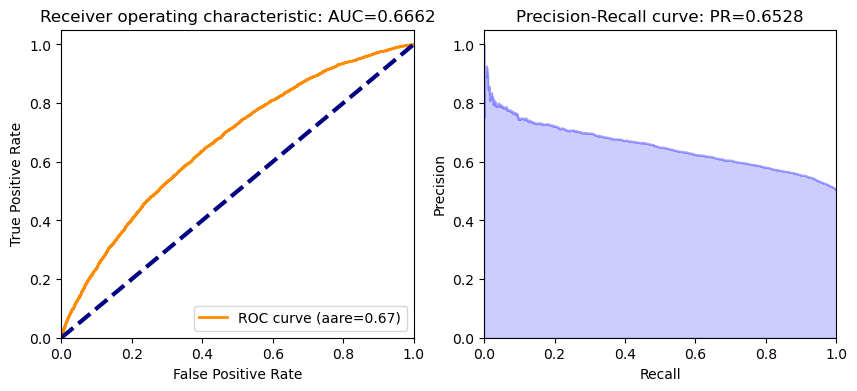

In [74]:
ROC_AUC(rf_v5,test_hex,'loan_default')

#### Nearest Neighbours Clearning Rule 
The Neighborhood Cleaning Rule, or NCR for short, is an undersampling technique that combines both the Condensed Nearest Neighbor (CNN) Rule to remove redundant examples and the Edited Nearest Neighbors (ENN) Rule to remove noisy or ambiguous examples.

The number of neighbors used in the ENN and CNN steps can be specified via the n_neighbors argument that defaults to three. The threshold_cleaning controls whether or not the CNN is applied to a given class, which might be useful if there are multiple minority classes with similar sizes. This is kept at 0.5.

In [75]:
# NeighbourhoodCleaningRule
sampler = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
X_rs, y_rs = sampler.fit_sample(X, y)
print('NearestNeighbours Clearning Rule undersampling {}'.format(Counter(y_rs)))
df = pd.concat([X_rs,y_rs],axis=1, sort=False)

NearestNeighbours Clearning Rule undersampling Counter({0: 34903, 1: 15488})


In [76]:
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [77]:
rf_v6 = H2ORandomForestEstimator(
        model_id = 'rf_v6',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v6.train(list(predictors),target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [78]:
createGains(rf_v6)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2016,1097,919,2016,1097,919,0.18,0.07,623.8,1.76,11.0,54.41
1,2016,946,1070,4032,2043,1989,0.33,0.14,1247.6,1.64,19.0,50.67
2,2016,796,1220,6048,2839,3209,0.46,0.23,1871.4,1.52,23.0,46.94
3,2015,698,1317,8063,3537,4526,0.57,0.33,2495.2,1.42,24.0,43.87
4,2016,628,1388,10079,4165,5914,0.67,0.42,3119.0,1.34,25.0,41.32
5,2016,559,1457,12095,4724,7371,0.76,0.53,3742.8,1.26,23.0,39.06
6,2015,517,1498,14110,5241,8869,0.84,0.64,4366.6,1.20,20.0,37.14
7,2016,421,1595,16126,5662,10464,0.91,0.75,4990.4,1.13,16.0,35.11
8,2016,364,1652,18142,6026,12116,0.97,0.87,5614.2,1.07,10.0,33.22


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



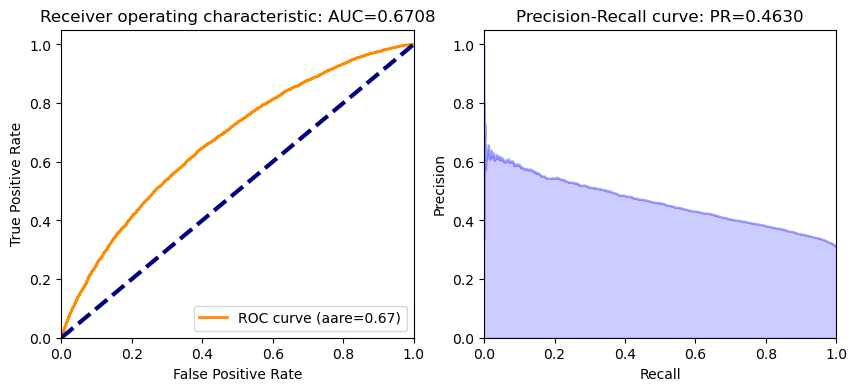

In [79]:
ROC_AUC(rf_v6,test_hex,'loan_default')

#### Near Miss
Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.

Here, distance is determined in feature space using Euclidean distance or similar.

- NearMiss-1: Majority class examples with minimum average distance to three closest minority class examples.
- NearMiss-2: Majority class examples with minimum average distance to three furthest minority class examples.
- NearMiss-3: Majority class examples with minimum distance to each minority class example.

In [80]:
# NearMiss-3 that selects the closest examples from the majority class for each minority class.
sampler = NearMiss(version=3, n_neighbors=3)
X_rs, y_rs = sampler.fit_sample(X, y)
print('NearMiss{}'.format(Counter(y_rs)))
df = pd.concat([X_rs,y_rs],axis=1, sort=False)

NearMissCounter({0: 15488, 1: 15488})


In [81]:
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [82]:
rf_v7 = H2ORandomForestEstimator(
        model_id = 'rf_v7',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v7.train(list(predictors),target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [83]:
createGains(rf_v7)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1240,1238,2,1240,1238,2,0.20,0.00,623.9,1.98,20.0,99.84
1,1239,1131,108,2479,2369,110,0.38,0.02,1247.8,1.90,36.0,95.56
2,1239,854,385,3718,3223,495,0.52,0.08,1871.7,1.72,44.0,86.69
3,1239,640,599,4957,3863,1094,0.62,0.18,2495.6,1.55,44.0,77.93
4,1239,589,650,6196,4452,1744,0.71,0.28,3119.5,1.43,43.0,71.85
5,1239,492,747,7435,4944,2491,0.79,0.40,3743.4,1.32,39.0,66.50
6,1239,439,800,8674,5383,3291,0.86,0.53,4367.3,1.23,33.0,62.06
7,1239,347,892,9913,5730,4183,0.92,0.68,4991.2,1.15,24.0,57.80
8,1239,302,937,11152,6032,5120,0.97,0.83,5615.1,1.07,14.0,54.09


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



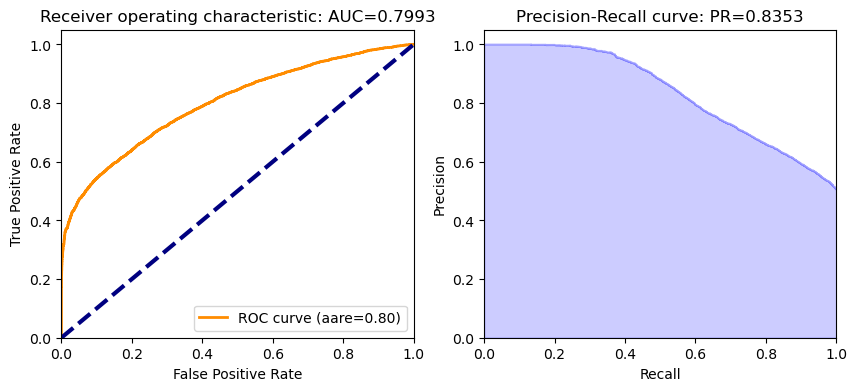

In [84]:
ROC_AUC(rf_v7,test_hex,'loan_default')

**Undersampling**: Overall, I used 3 out of 7 undersampling methods to evaluate the random forest performance which are Random under-sampling for the majority class, Nearest Neighbours Cleaning Rule, and Near Miss. From these approaches, the NearMiss method had the best results compared to the other two in both the gain table and the scores of AUC and AUCPR. 

However, with undersampling methods, there is a possibility of a loss in classification performance, thus the scores might not be reliable to realistic problems. However, I would recommend apply the models to the real world use case to track and evaulate performance in a live setting.


### Oversampling

OVersampling is another technique to deal with extremely imbalanced data. Oversampling increases the weight of the minority class by replicating the minority class examples. Although it does not increase information, it raises the over-fitting issue, which causes the model to be too specific. 

There are 3 common oversampling techniques, as following:
- Random oversampling for the minority class
- Synthetic Minority Oversampling Technique (SMOTE)
- ADASYN: Adaptive Synthetic Sampling.

[Reference](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)

In [85]:
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN)

#### Random oversampling for the minority class
Random oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset.This means that examples from the minority class can be chosen and added to the new “more balanced” training dataset multiple times. They are selected from the original training dataset, added to the new training dataset, and then returned or “replaced” in the original dataset, allowing them to be selected again.

The random oversampling may increase the likelihood of overfitting, since it makes exact copies of the minority class examples.

In [86]:
sampler = RandomOverSampler(sampling_strategy='minority')
X_rs, y_rs = sampler.fit_sample(X, y)
print('RandomOverSampler {}'.format(Counter(y_rs)))
df = pd.concat([X_rs,y_rs],axis=1, sort=False)

RandomOverSampler Counter({1: 64512, 0: 64512})


In [87]:
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [88]:
rf_v8 = H2ORandomForestEstimator(
        model_id = 'rf_v8',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v8.train(list(predictors),target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [89]:
createGains(rf_v8)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,5161,4076,1085,5161,4076,1085,0.16,0.04,2578.0,1.58,12.0,78.98
1,5161,3546,1615,10322,7622,2700,0.30,0.10,5156.0,1.48,20.0,73.84
2,5161,3275,1886,15483,10897,4586,0.42,0.18,7734.0,1.41,24.0,70.38
3,5161,3127,2034,20644,14024,6620,0.54,0.26,10312.0,1.36,28.0,67.93
4,5161,2868,2293,25805,16892,8913,0.66,0.35,12890.0,1.31,31.0,65.46
5,5161,2528,2633,30966,19420,11546,0.75,0.45,15468.0,1.26,30.0,62.71
6,5161,2164,2997,36127,21584,14543,0.84,0.56,18046.0,1.20,28.0,59.74
7,5161,1962,3199,41288,23546,17742,0.91,0.69,20624.0,1.14,22.0,57.03
8,5161,1410,3751,46449,24956,21493,0.97,0.83,23202.0,1.08,14.0,53.73


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



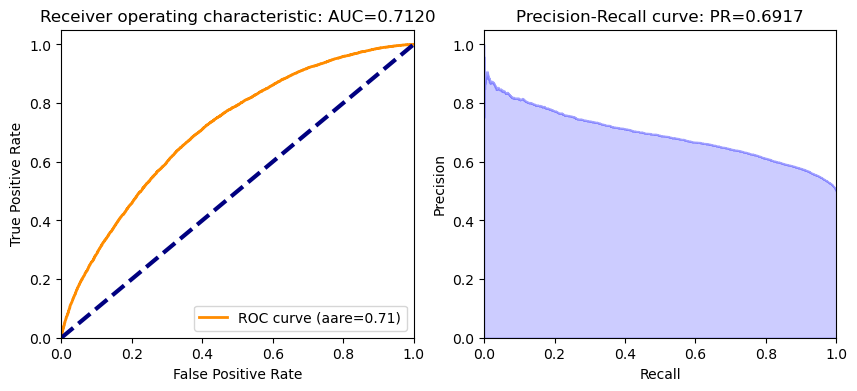

In [90]:
ROC_AUC(rf_v8,test_hex,'loan_default')

####  Synthetic Minority Oversampling Technique (SMOTE)
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes.

In [91]:
sampler = SMOTE(sampling_strategy='minority',random_state=42)
X_rs, y_rs = sampler.fit_sample(X, y)
print('SMOTE {}'.format(Counter(y_rs)))
df = pd.concat([X_rs,y_rs],axis=1, sort=False)

SMOTE Counter({1: 64512, 0: 64512})


The dataset is transformed using the SMOTE and the new class distribution is summarized, showing a balanced distribution now with 64,512 examples in the minority class

In [92]:
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [93]:
rf_v9 = H2ORandomForestEstimator(
        model_id = 'rf_v9',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v9.train(list(predictors),target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [94]:
createGains(rf_v9)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,5161,5161,0,5161,5161,0,0.20,0.00,2578.0,2.00,20.0,100.00
1,5161,5116,45,10322,10277,45,0.40,0.00,5156.0,1.99,40.0,99.56
2,5161,4678,483,15483,14955,528,0.58,0.02,7734.0,1.93,56.0,96.59
3,5161,3455,1706,20644,18410,2234,0.71,0.09,10312.0,1.79,62.0,89.18
4,5161,2238,2923,25805,20648,5157,0.80,0.20,12890.0,1.60,60.0,80.02
5,5161,1669,3492,30966,22317,8649,0.87,0.33,15468.0,1.44,54.0,72.07
6,5161,1300,3861,36127,23617,12510,0.92,0.48,18046.0,1.31,44.0,65.37
7,5161,1017,4144,41288,24634,16654,0.96,0.64,20624.0,1.19,32.0,59.66
8,5161,744,4417,46449,25378,21071,0.98,0.82,23202.0,1.09,16.0,54.64


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



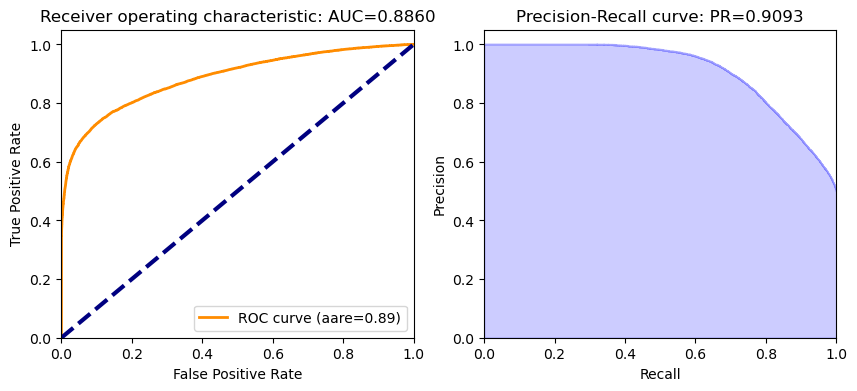

In [95]:
ROC_AUC(rf_v9,test_hex,'loan_default')

#### ADASYN: Adaptive Synthetic Sampling

The key idea of ADASYN algorithm is to use a density distribution as a criterion to automatically decide the number of synthetic samples that need to be generated for each minority data example.

In [96]:
sampler = ADASYN(sampling_strategy='minority',random_state=42)
X_rs, y_rs = sampler.fit_sample(X, y)
print('ADASYN {}'.format(Counter(y_rs)))
df = pd.concat([X_rs,y_rs],axis=1, sort=False)

ADASYN Counter({0: 64512, 1: 63268})


In [97]:
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [98]:
rf_v10 = H2ORandomForestEstimator(
        model_id = 'rf_v10',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v10.train(list(predictors),target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [99]:
createGains(rf_v10)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,5112,5112,0,5112,5112,0,0.20,0.00,2530.5,2.02,20.0,100.00
1,5111,5048,63,10223,10160,63,0.40,0.00,5061.0,2.01,40.0,99.38
2,5111,4584,527,15334,14744,590,0.58,0.02,7591.5,1.94,56.0,96.15
3,5111,3371,1740,20445,18115,2330,0.72,0.09,10122.0,1.79,63.0,88.60
4,5111,2256,2855,25556,20371,5185,0.81,0.20,12652.5,1.61,61.0,79.71
5,5112,1600,3512,30668,21971,8697,0.87,0.34,15183.0,1.45,53.0,71.64
6,5111,1224,3887,35779,23195,12584,0.92,0.49,17713.5,1.31,43.0,64.83
7,5111,1002,4109,40890,24197,16693,0.96,0.65,20244.0,1.20,31.0,59.18
8,5111,700,4411,46001,24897,21104,0.98,0.82,22774.5,1.09,16.0,54.12


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



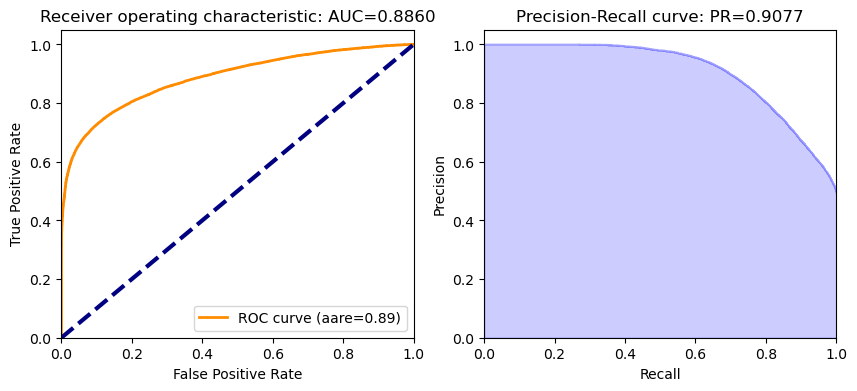

In [100]:
ROC_AUC(rf_v10,test_hex,'loan_default')

**Oversampling**: Overall, the results of ADASYN and SMOTE are extremely similar in the gains table and AUC and AUCPR scores. The two models here also provided better results than the random oversampling for the minority class approach. However, with oversampling methods, there is a possibility of overfitting, thus the scores might not be reliable to realistic problems. However, I would recommend applying the model to the real world use case and monitor its performance over time. 

### Conclusion

The given dataset has high level of negative-positive impact to users. Based on my observations, the predictive power increases when we apply optimal hyperparementers. Additionally, the dataset has a wide-range of date and time, which may be investigated further because the variable seems like a good choice for prediction. 

Both undersampling and oversampling result in high AUC scores, compared to the best random forest model I generated. However, the lift score in the gain table of the best random forest model is better. This insight leads me to consider what would work best in a real life use case and I would like to further examine the results with newly generated data to gauge further performance before deciding which one stands out as the best.

If I spent more time on generating and exploring the date-time variable, it could support the predictive models performance. Additionally, I would have liked to spend further time in generating features that have predictive power, such as date data. I am curious how it would affect the model performance if we split the data by date. From my assumption, by splitting the data by date, I would be able to understand how the model would predict with future data, thus simulating the result to the real world problem.